[INFO] Loaded 882097 examples across 6 classes.
[INFO] Number of labels: 6 -> ['anger', 'fear', 'happy', 'neutral', 'ps', 'sad']
[INFO] Tokenizing texts (this may take a moment)...

[Sample - raw text]
@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[


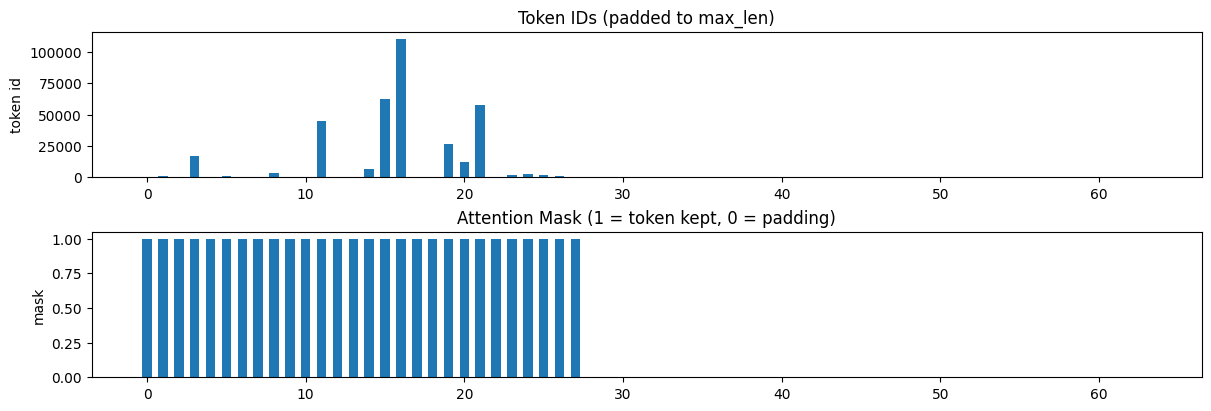

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17996\906249360.py:195: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
Epoch 1/4:   0%|          | 0/11027 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_17996\906249360.py:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
C:\Users\Administrator\AppData\Local\Temp\ipyke

Epoch [1/4] Train Acc: 93.85% | Val Acc: 97.20%
[INFO] Best model saved with Val Acc: 97.20% -> K:\Code\Project\Research Paper\Emotion Detection\Code\best_xlm_roberta.pth


Epoch 2/4:  19%|█▊        | 2048/11027 [13:55<1:00:37,  2.47it/s, Loss=0.0755, TrainAcc=97.38%]

In [ ]:
"""
Optimized XLM-RoBERTa multilingual emotion classifier (PyTorch)
- Keeps CSV layout: 'content' (text) and 'sentiment' (label)
- Uses xl m-roberta-base
- Shows one sample before & after preprocessing (raw text vs token ids/attention mask)
- Shows training & validation accuracy per epoch (tqdm), saves best model
- Plots: Val Accuracy vs Epoch, Confusion Matrix, Multi-class ROC
"""

import os
import time
import random
import copy
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# ------------------------
# Settings (edit paths if needed)
# ------------------------
CSV_PATHS = [
    r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\tweet_emotions.csv",
    r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\dataset2.csv",
    r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\dataset3_excel.csv"
]
MODEL_NAME = "xlm-roberta-base"
MAX_LEN = 64
BATCH_SIZE = 64
EPOCHS = 4         # you can set 50 later; kept small here for quick tests
LR = 2e-5
WEIGHT_DECAY = 1e-2
WARMUP_RATIO = 0.1
BEST_MODEL_PATH = r"K:\Code\Project\Research Paper\Emotion Detection\Code\best_xlm_roberta.pth"
EMOTIONS_NPY = r"K:\Code\Project\Research Paper\Emotion Detection\Code\emotions.npy"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# Performance
NUM_WORKERS = 0
PIN_MEMORY = True if torch.cuda.is_available() else False

# Repro
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.benchmark = True

# Try to silence dynamo triton errors on some machines
try:
    import torch._dynamo as _dynamo
    _dynamo.config.suppress_errors = True
except Exception:
    pass

# ------------------------
# Data loading & preparation
# ------------------------
def load_and_prepare(csv_paths: List[str]) -> Tuple[List[str], List[str], LabelEncoder]:
    dfs = []
    for p in csv_paths:
        if os.path.exists(p):
            dfs.append(pd.read_csv(p))
        else:
            print(f"[WARN] CSV not found, skipping: {p}")
    if not dfs:
        raise RuntimeError("No CSV files found. Update CSV_PATHS.")
    df = pd.concat(dfs, ignore_index=True)
    if "content" not in df.columns or "sentiment" not in df.columns:
        raise RuntimeError("CSV files must contain 'content' and 'sentiment' columns.")
    df = df.dropna(subset=["content", "sentiment"])
    df["content"] = df["content"].astype(str).str.strip()
    df = df[df["content"] != ""]
    df = df[df["sentiment"].str.lower() != "pray"]
    # label encode
    le = LabelEncoder()
    df["label"] = le.fit_transform(df["sentiment"])
    texts = df["content"].tolist()
    labels = df["label"].tolist()
    print(f"[INFO] Loaded {len(texts)} examples across {len(le.classes_)} classes.")
    return texts, labels, le

# ------------------------
# Dataset using pre-tokenized tensors
# ------------------------
class TokenizedTextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.labels.size(0)

    def __getitem__(self, idx):
        item = {k: self.enc[k][idx] for k in self.enc}
        item["labels"] = self.labels[idx]
        return item

# ------------------------
# Utility: show one sample before & after preprocessing
# ------------------------
def show_sample_preprocessing(text: str, tokenizer, max_len: int = MAX_LEN):
    print("\n[Sample - raw text]")
    print(text)
    enc = tokenizer(text, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")
    input_ids = enc["input_ids"][0].cpu().numpy()
    attn = enc["attention_mask"][0].cpu().numpy()

    # Visualize token IDs as a bar plot and attention mask as a separate subplot
    fig, axes = plt.subplots(2, 1, figsize=(12, 4), constrained_layout=True)
    axes[0].bar(range(len(input_ids)), input_ids, width=0.6)
    axes[0].set_title("Token IDs (padded to max_len)")
    axes[0].set_ylabel("token id")
    axes[1].bar(range(len(attn)), attn, width=0.6)
    axes[1].set_title("Attention Mask (1 = token kept, 0 = padding)")
    axes[1].set_ylabel("mask")
    plt.show()

# ------------------------
# Plot helpers
# ------------------------
def plot_accuracy(train_accs: List[float], val_accs: List[float]):
    epochs = range(1, len(train_accs) + 1)
    plt.figure(figsize=(7,4))
    plt.plot(epochs, train_accs, marker='o', label="Train Acc")
    plt.plot(epochs, val_accs, marker='o', label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Validation Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc(y_true, y_score, class_names):
    try:
        y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
        n_classes = y_true_bin.shape[1]
        plt.figure(figsize=(8,6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
        # micro-average
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        plt.plot(fpr, tpr, label=f"micro (AUC={auc(fpr, tpr):.2f})", linestyle='--', linewidth=2)
        plt.plot([0,1],[0,1],'k--', linewidth=0.6)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Multi-class ROC")
        plt.legend(fontsize='small', loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("[WARN] ROC plotting failed:", e)

# ------------------------
# Training & evaluation loop
# ------------------------
def train_loop(model, train_loader, val_loader, optimizer, scheduler, epochs, device, save_path):
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
    best_val_acc = -1.0
    best_state = None
    train_accs = []
    val_accs = []

    for epoch in range(1, epochs + 1):
        model.train()
        total = 0
        correct = 0
        running_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for batch in pbar:
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            if scheduler is not None:
                scheduler.step()

            preds = logits.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            running_loss += loss.item() * labels.size(0)

            train_acc = 100.0 * correct / total
            avg_loss = running_loss / total
            pbar.set_postfix({"Loss": f"{avg_loss:.4f}", "TrainAcc": f"{train_acc:.2f}%"})

        epoch_train_acc = 100.0 * correct / total
        train_accs.append(epoch_train_acc)
        # Validation
        model.eval()
        v_total = 0
        v_correct = 0
        all_targets = []
        all_probs = []
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
            for batch in val_loader:
                ids = batch["input_ids"].to(device)
                mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                out = model(ids, attention_mask=mask)
                probs = nn.functional.softmax(out.logits, dim=1)
                preds = probs.argmax(dim=1)
                v_total += labels.size(0)
                v_correct += (preds == labels).sum().item()
                all_targets.append(labels.cpu().numpy())
                all_probs.append(probs.cpu().numpy())

        epoch_val_acc = 100.0 * v_correct / v_total if v_total > 0 else 0.0
        val_accs.append(epoch_val_acc)
        print(f"Epoch [{epoch}/{epochs}] Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

        # Save best
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_state = {
                "epoch": epoch,
                "model_state": copy.deepcopy(model.state_dict()),
                "optimizer_state": optimizer.state_dict(),
                "val_acc": best_val_acc
            }
            torch.save(best_state["model_state"], save_path)
            print(f"[INFO] Best model saved with Val Acc: {best_val_acc:.2f}% -> {save_path}")

    # collect final val targets/probs for plotting
    if all_probs:
        y_score = np.vstack(all_probs)
        y_true = np.concatenate(all_targets)
    else:
        y_score = np.array([])
        y_true = np.array([])

    return {
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_state": best_state,
        "y_true": y_true,
        "y_score": y_score
    }

# ------------------------
# Main
# ------------------------
def main():
    texts, labels, le = load_and_prepare(CSV_PATHS)
    class_names = list(le.classes_)
    num_classes = len(class_names)
    print(f"[INFO] Number of labels: {num_classes} -> {class_names}")

    # Save label mapping
    os.makedirs(os.path.dirname(EMOTIONS_NPY), exist_ok=True)
    np.save(EMOTIONS_NPY, class_names)

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
    print("[INFO] Tokenizing texts (this may take a moment)...")
    enc = tokenizer(texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
    show_sample_preprocessing(texts[0], tokenizer, max_len=MAX_LEN)

    train_idx, val_idx = train_test_split(
        list(range(len(texts))), test_size=0.2, random_state=SEED, stratify=labels
    )

    enc_train = {k: v[train_idx] for k, v in enc.items()}
    enc_val = {k: v[val_idx] for k, v in enc.items()}
    y_train = [labels[i] for i in train_idx]
    y_val = [labels[i] for i in val_idx]

    train_ds = TokenizedTextDataset(enc_train, y_train)
    val_ds = TokenizedTextDataset(enc_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_classes).to(DEVICE)
    try:
        model.gradient_checkpointing_enable()
    except Exception:
        pass

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, int(WARMUP_RATIO * total_steps), total_steps)

    # === Load existing model ===
    choice = input("Load saved model? (yes/no): ").strip().lower()
    if choice == "yes" and os.path.exists(BEST_MODEL_PATH):
        print("[INFO] Loading saved model weights from", BEST_MODEL_PATH)
        model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
        model.to(DEVICE)
        model.eval()
        all_targets, all_probs = [], []
        with torch.no_grad():
            for batch in val_loader:
                ids = batch["input_ids"].to(DEVICE)
                mask = batch["attention_mask"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)
                out = model(ids, attention_mask=mask)
                probs = nn.functional.softmax(out.logits, dim=1).cpu().numpy()
                all_probs.append(probs)
                all_targets.append(labels.cpu().numpy())

        y_score = np.vstack(all_probs)
        y_true = np.concatenate(all_targets)
        y_pred = np.argmax(y_score, axis=1)

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        plot_confusion_matrix(cm, class_names)
        plot_multiclass_roc(y_true, y_score, class_names)
        return

    # === Train ===
    t0 = time.time()
    stats = train_loop(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, DEVICE, BEST_MODEL_PATH)
    print(f"[INFO] Training finished in {(time.time()-t0)/60:.2f} minutes.")
    plot_accuracy(stats["train_accs"], stats["val_accs"])

    # Load best model
    if stats["best_state"] is not None:
        model.load_state_dict(stats["best_state"]["model_state"])
        print(f"[INFO] Best model loaded (epoch {stats['best_state']['epoch']}, val acc {stats['best_state']['val_acc']:.2f}%)")

    # === Evaluation Metrics ===
    if stats["y_score"].size != 0:
        y_true = stats["y_true"]
        y_score = stats["y_score"]
        y_pred = np.argmax(y_score, axis=1)

        print("\nClassification Report (Precision, Recall, F1-Score):")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        plot_confusion_matrix(cm, class_names)
        plot_multiclass_roc(y_true, y_score, class_names)
    else:
        print("[WARN] No validation predictions available for plotting.")

    print("[DONE]")


if __name__ == "__main__":
    main()
